### Assignment 1 Part III - KG searching, weighting, and embedding

**Overview:** In this notebook, you will learn how to a couple of different ways search to through a large knowledge graph, how to reweight the knowledge graph to favor specific paths, and how to embed nodes in the knowledge graph to try and fill in gaps.   

#### Part I - a couple of different ways search to through a large knowledge graph

These first cells simply set up some variables that will be used below

TODO: get username from the Jupyter and put that in the path

In [1]:
import os
import sys
#sys.path.append('/ihome/rboyce/{}/.conda/envs/bionf2071/lib/python3.7/site-packages/'.format(os.getenv('JUPYTERHUB_USER')))

In [2]:
# There can be many paths of the same length so you can adjust how many you want returned
maxNumPaths = 5

You can populate the list in the next cell with the start and end nodes that you will use to search for paths in the knowledge graph. The [PheKnowLator overview](https://user-images.githubusercontent.com/8030363/103158881-11813b00-4780-11eb-8b45-5063765e7645.png) shows all of the ontologies loaded into the knowledge graph as orange boxes. You can replace the start and end nodes with entities that interest you in those ontologies by going to [Ontobee](http://www.ontobee.org/) and obtaining the URIs and then replacing the start and end node pairs in the s_o_tpl_L list. Be sure to set FIRST_TO_PROCESS to the first pair. If you have to restart the knowledge graph searches shown later, you can change that variable.

The libraries needed to import the graph and work with it

In [3]:
import os
import os.path
import networkx as nx
import json
import urllib
import traceback
import sys
from itertools import islice
from rdflib import Graph, URIRef, BNode, Namespace, Literal
from rdflib.namespace import RDF, OWL
#import smart_open
#from node2vec import Node2Vec

The next two cell are the graph loading step. The graph is the output of the PheKnowLator process including filtering out OWL semantics. The sources used in this version of the knowledge graph are listed on [this Wiki page](https://github.com/callahantiff/PheKnowLator/wiki/v2-Data-Sources). The graph takes more than 15 gigs of RAM once loaded.

In [4]:
GRAPHPATH = "/home/sanya/PheKnowLator/resources/knowledge_graphs/PheKnowLator_v2.1.0_full_instance_inverseRelations_OWLNETS_NetworkxMultiDiGraph.gpickle"

In [5]:
# Reloading the graph produced from the PheKnowLator workflow
# The graph 
nx_mdg = nx.read_gpickle(GRAPHPATH)

The next cell defines several functions that will help to explain the results of path searches.

In [9]:
ontobee_service = "http://sparql.hegroup.org/sparql/"


def query(q,epr,f='application/sparql-results+json'):
    """Function that uses urllib/urllib2 to issue a SPARQL query.
       By default it requests json as data format for the SPARQL resultset"""

    try:
        params = {'query': q}
        params = urllib.parse.urlencode(params)
        opener = urllib.request.build_opener(urllib.request.HTTPHandler)
        request = urllib.request.Request(epr+'?'+params)
        request.add_header('Accept', f)
        request.get_method = lambda: 'GET'
        url = opener.open(request)
        return url.read()
    except Exception as e:
        traceback.print_exc(file=sys.stdout)
        raise e


def pathQuery(pth):
    """Given a single path (list of rdflib objects), run a sparql query to retrieve descriptive information 
       that will help construct a narrative explanation"""
    
    uriL = [x.toPython() for x in filter(lambda x: type(x) == URIRef, pth)]
    subjectStr = ''
    objectStr = ''
    for uri in uriL:
        subjectStr = subjectStr + '?s = <' + uri + '> || '
        objectStr = objectStr + '?o = <' + uri + '> || '
    subjectStr = subjectStr[:-3] # ?s = <..> || ?s = <...>... the URIs for the subject/object entities in the path
    objectStr = objectStr[:-3] # ?o = <..> || ?o = <...>... the URIs for the subject/object entities in the path
   
    q = '''
  prefix obo:<http://purl.obolibrary.org/obo/>
  prefix owl:<http://www.w3.org/2002/07/owl#>
  prefix napdi:<http://napdi.org/napdi_srs_imports:>
 
  select distinct ?s ?p ?o ?p_lab ?s_lab_eg ?o_lab_eg
  from <http://phenowlator-st.org>
  from <ro_with_imports_AD_mods>
  where {{
    ?s ?p ?o.FILTER(({}) && ({})) 
    OPTIONAL{{
     ?p rdfs:label ?p_lab.
   }}
   OPTIONAL{{
     ?egM_s <http://dikb.org/ad#obo_mapping> ?s.
     ?egM_s rdfs:label ?s_lab_eg.
   }}
   OPTIONAL{{
     ?egM_o <http://dikb.org/ad#obo_mapping> ?o.
     ?egM_o rdfs:label ?o_lab_eg.
   }}
  }}
'''.format(subjectStr,objectStr)
    
    return q


def missingLabelQuery(uri, endpoint):
    query_string = '''
SELECT distinct ?lab
WHERE {{ 
 <{}> rdfs:label ?lab. 
}}
'''.format(uri)
    json_string = query(query_string, endpoint)
    resultset = json.loads(json_string)
    rsltsD = {}
    for b in resultset["results"]["bindings"]:
        if not b.get('lab'):
            return None
        
        label = b['lab']['value']
        if label:
            return label
        else:
            return None

def constructPathNarData(pth, sparql_service, debug=False):
    """ Iterate through the path to organize a narrative
        in: pth - a list of rdflib URIRef and BNode objects
        in: sparql_service - URL to the sparql endpoint
    """
    query_string = pathQuery(pth)
    if debug:
        print('[DEBUG] Query:\n' + query_string)
        
    json_string = query(query_string, pheknowlator_service)
    resultset = json.loads(json_string)
    print("[INFO] Number of results: " + str(len(resultset["results"]["bindings"])))
    
    # Re-organize the results set to be a dict keyed by the subject uri
    rsltsD = {}
    for b in resultset["results"]["bindings"]:
        s = b['s']['value']
        if rsltsD.get(s):
            rsltsD[s].append(b)
        else:
            rsltsD[s] = [b]
    
    narrative = ""     
    for i in range(0,len(pth)):
        if i == len(pth) - 1:
            break
        
        n1 = pth[i]
        n2 = pth[i+1]
    
        if not (type(n1) == URIRef and type(n2) == URIRef):
            narrative += "----- BLANK NODE STEP ----"
            continue
        else:
            # locate the results dict that relates n1 to n2 in a subject, predicate, object triple
            o_d = None
            for d in rsltsD.get(n1.toPython()):
                if d['o']['value'] == n2.toPython():
                    o_d = d
                    break
        
            if not o_d:
                print("ERROR: Unable to find a triple relating {} to {} in path {}".format(n1.toPython(),n2.toPython(),pth))
            else:
                o_lab = '<no label found>'
                o_node_id = o_d['o']['value'].split('/')[-1]
                if nodeLabD.get(o_node_id):
                    o_lab = nodeLabD[o_node_id]
                else:
                    if label_cache.get(o_d['o']['value']):
                        o_lab = label_cache[o_d['o']['value']]
                    else:
                        ql = missingLabelQuery(o_d['o']['value'],ontobee_service)
                        if ql:
                            label_cache[o_d['o']['value']] = ql
                            o_lab = ql
                    
                    if o_lab == '<no label found>' and o_d.get('o_lab_eg'):
                        o_lab = o_d['o_lab_eg']['value'] + ' (UMLS label)'

                s_lab = '<no label found>'
                s_node_id = o_d['s']['value'].split('/')[-1]
                if nodeLabD.get(s_node_id):
                    s_lab = nodeLabD[s_node_id]
                else:
                    if label_cache.get(o_d['s']['value']):
                        s_lab = label_cache[o_d['s']['value']]
                    else:
                        ql = missingLabelQuery(o_d['s']['value'],ontobee_service)
                        if ql:
                            label_cache[o_d['s']['value']] = ql
                            s_lab = ql  
                    
                    if s_lab == '<no label found>' and o_d.get('s_lab_eg'):
                        s_lab = o_d['s_lab_eg']['value'] + ' (UMLS label)'

                if o_d.get('p_lab'):                      
                    narrative += '{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                            s_lab,o_d['p_lab']['value'],o_lab,
                            o_d['s']['value'],o_d['p']['value'],o_d['o']['value']
                           )                          
                else:
                    narrative += '{}\t{}\t{}\t{}\t{}\t{}\n'.format(
                            s_lab,o_d['p']['value'].replace('http://www.w3.org/2000/01/rdf-schema#',''),o_lab,
                            o_d['s']['value'],o_d['p']['value'],o_d['o']['value']
                           )                                          
    return narrative

The next cell loads a file that has all of the node labels which were stripped from the graph when OWL semantics were removed.

In [6]:
nodeLabD = {}
node_label_file = '/home/sanya/PheKnowLator/resources/knowledge_graphs/PheKnowLator_v2.1.0_full_instance_inverseRelations_OWLNETS_NodeLabels.txt'
f = open(node_label_file,'r')
buf = f.read()
f.close()
nodLabL = buf.split('\n')
for line in nodLabL:
    spL = line.split('\t')
    if len(spL) > 1:
        nodeLabD[spL[0]] = spL[1]

In [30]:
for key in nodeLabD:
    print(key)
    print(nodeLabD[key])
    break

entity_type
integer_id


This function conducts a shortest path search given a graph source and target k results are returned

In [7]:
def k_shortest_paths(G, source, target, k, weight='weight'):
    return list(islice(nx.all_shortest_paths(G, source, target, weight=weight), k))

This function conducts the simple path searches given a graph source and target and an integers with the shortest path length known 
The shortest path lengths is used so that already seen simple paths are not returned
k results are returned

In [8]:
def k_simple_paths(G, source, target, k, shortestLen):
    paths = nx.all_simple_paths(G, source, target, cutoff=shortestLen+20)
    path_l = []
    i = 0
    while i < k:
        try:
            print('[info] applying next operator to search for a simple path of max length {}'.format(shortestLen+20))
            path = next(paths)
        except StopIteration:
            break
        print('[info] Simple path found of length {}'.format(len(path))) 
        if len(path) > shortestLen:
            print('[info] Simple path length greater than shortest path length ({}) so adding to results'.format(shortestLen))
            path_l.append(path)
        i += 1
    return path_l      

In [9]:
# This is the endpoint where an RDF version of the PheKnowLator graph resides
pheknowlator_service = "http://localhost:8890/sparql"

In [10]:
# There can be allot of repetition when doing certain search patterns (e.g., confounders) so set up a cache 
processed_tpl_cache = []
# queried label cache
label_cache = {}

In [11]:
from rdflib import Namespace
obo = Namespace('http://purl.obolibrary.org/obo/')
napdi = Namespace('http://napdi.org/napdi_srs_imports:')

In [12]:
s_o_tpl_List = [
    (napdi.camellia_sinensis_leaf,obo.CHEBI_42255),
    (napdi.camellia_sinensis_leaf,obo.CHEBI_68330),
    (napdi.camellia_sinensis_leaf,obo.CHEBI_90),
    (napdi.camellia_sinensis_leaf,obo.CHEBI_70255),
    (napdi.camellia_sinensis_leaf,obo.PR_P08684),
    (napdi.camellia_sinensis_leaf,obo.HP_0003418),
    (napdi.camellia_sinensis_leaf,obo.CHEBI_8871)
]
## Leave as None unless you have to restart this cell before it has completely processed all tuples.
## Otherwise, replace this tuple with the first tuple to process completely by the program 
FIRST_TO_PROCESS =  None

In [13]:
s_o_tpl_L = [(napdi.camellia_sinensis_leaf,obo.PR_P08684)]

In [14]:
napdi.camellia_sinensis_leaf

rdflib.term.URIRef('http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf')

In [32]:
#get shortest path from green tea leaf
chebi_90_path = nx.single_source_shortest_path(nx_mdg, napdi.camellia_sinensis_leaf)
count = 0
for k, v in chebi_90_path.items():
    count += 1
    if k != napdi.camellia_sinensis_leaf:
        print('\n{} - {} Path:'.format(str(napdi.camellia_sinensis_leaf).split('/')[-1], str(k).split('/')[-1]))
        for i in v:
            print(i)
    if count == 10:
        break


napdi_srs_imports:camellia_sinensis_leaf - napdi_srs_imports:camellia_sinensis_whole Path:
http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf
http://napdi.org/napdi_srs_imports:camellia_sinensis_whole

napdi_srs_imports:camellia_sinensis_leaf - CHEBI_42255 Path:
http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf
http://purl.obolibrary.org/obo/CHEBI_42255

napdi_srs_imports:camellia_sinensis_leaf - CHEBI_68330 Path:
http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf
http://purl.obolibrary.org/obo/CHEBI_68330

napdi_srs_imports:camellia_sinensis_leaf - CHEBI_24431 Path:
http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf
http://purl.obolibrary.org/obo/CHEBI_24431

napdi_srs_imports:camellia_sinensis_leaf - napdi_srs_imports:epigallocatechin_gallate Path:
http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf
http://napdi.org/napdi_srs_imports:epigallocatechin_gallate

napdi_srs_imports:camellia_sinensis_leaf - NCBITaxon_4442 Path:
http://napdi.org/napdi_srs

In [46]:
nx.bidirectional_shortest_path(nx_mdg, napdi.camellia_sinensis_leaf, obo.CHEBI_10033)

[rdflib.term.URIRef('http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_24431'),
 rdflib.term.URIRef('https://reactome.org/content/detail/R-HSA-1430728'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_10033')]

In [15]:
cyp3a4_paths = k_simple_paths(nx_mdg, napdi.camellia_sinensis_leaf, obo.PR_P08684, 10, 4)

[info] applying next operator to search for a simple path of max length 24
[info] Simple path found of length 25
[info] Simple path length greater than shortest path length (4) so adding to results
[info] applying next operator to search for a simple path of max length 24
[info] Simple path found of length 25
[info] Simple path length greater than shortest path length (4) so adding to results
[info] applying next operator to search for a simple path of max length 24
[info] Simple path found of length 25
[info] Simple path length greater than shortest path length (4) so adding to results
[info] applying next operator to search for a simple path of max length 24
[info] Simple path found of length 25
[info] Simple path length greater than shortest path length (4) so adding to results
[info] applying next operator to search for a simple path of max length 24
[info] Simple path found of length 25
[info] Simple path length greater than shortest path length (4) so adding to results
[info] app

In [24]:
for key in nodeLabD:
    print(key)
    print(nodeLabD[key])
    break

entity_type
integer_id


In [29]:
#translate nodes to labels, figure out how to get relations/edges and then save to file
cyp3a4_paths[0]

[rdflib.term.URIRef('http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf'),
 rdflib.term.URIRef('http://napdi.org/napdi_srs_imports:camellia_sinensis_whole'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_24431'),
 rdflib.term.URIRef('https://reactome.org/content/detail/R-HSA-1430728'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/PR_Q96SU4'),
 rdflib.term.URIRef('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000428468'),
 rdflib.term.URIRef('http://www.ncbi.nlm.nih.gov/gene/114883'),
 rdflib.term.URIRef('https://reactome.org/content/detail/R-HSA-192105'),
 rdflib.term.URIRef('http://www.ncbi.nlm.nih.gov/gene/5740'),
 rdflib.term.URIRef('https://reactome.org/content/detail/R-HSA-2142753'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_34784'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_15904'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_35366'),
 rdflib.term.URIRef('http://purl.obolibrary.org/obo/GO

In [32]:
from tqdm import tqdm
for s,p,o in tqdm(nx_mdg):
    print(s)
    print(p)
    print(o)
    break

  0%|          | 0/743772 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 3)

In [18]:
with open('cyp3a4_paths_test.txt', 'w') as file_o:
    for item in cyp3a4_paths:
        file_o.write(str(item))
        file_o.write('/n/n')

TypeError: write() argument must be str, not list

In [16]:
backpain_paths = k_simple_paths(nx_mdg, napdi.camellia_sinensis_leaf, obo.HP_0003418, 10, 6)

[info] applying next operator to search for a simple path of max length 26


KeyboardInterrupt: 

In [ ]:
len(cyp3a4_paths)

In [ ]:
# look at shortest path between 
shortest_paths = nx.shortest_path(nx_mdg, source=napdi.camellia_sinensis_leaf)

for k, v in shortest_paths.items():
    if k != napdi.camellia_sinensis_leaf:
        print('\n{} - {} Path:'.format(str(napdi.camellia_sinensis_leaf).split('/')[-1], str(k).split('/')[-1]))
        for i in v:
            print(i)

The next cell conducts the shortest path searches

In [35]:
shortestPathsLens = [] # we track the shortest paths from source to target for when we do simple path searches
for tpl in s_o_tpl_L:      
    if FIRST_TO_PROCESS:
        if str(tpl) != str(FIRST_TO_PROCESS):
            print('INFO: skipping tuple because it is not FIRST_TO_PROCESS:' + str(tpl))
            continue
        else:
            FIRST_TO_PROCESS = None
    
    (s,o) = tpl    
    startNd = s
    endNd = o
    
    print('INFO: Processing {} and {}:\n'.format(s,o))
                
    try:
        pthL = k_shortest_paths(nx_mdg,startNd,endNd,maxNumPaths)
    except nx.NetworkXNoPath:
        print('INFO: No results in the path search.\n')
        continue
    except nx.NodeNotFound:
        print('INFO: The source node does not exist in the Knowledge Graph.\n')
        continue
    print(len(pthL))
    
    narL = []
    c = -1
    for path in pthL:
        print(path)
        if path is None:
            continue
        if c == -1:
            shortestPathsLens.append(len(path))
            
        c += 1
        nar = constructPathNarData(path,pheknowlator_service,debug=False)
        print('\n\nINFO: SHORTEST PATH {}:\n'.format(c))
        print(nar)
        print('\n\n')

INFO: Processing http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf and http://purl.obolibrary.org/obo/CHEBI_42255:

1
[rdflib.term.URIRef('http://napdi.org/napdi_srs_imports:camellia_sinensis_leaf'), rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_42255')]
[INFO] Number of results: 0


TypeError: 'NoneType' object is not iterable

The next cell conducts the simple path searches but in a way to ignores the shortest paths

In [ ]:
maxNumPaths = 3  # we search for fewer paths b/c this can take much longer than the shortest path searches  
tplCnt = 0
for tpl in s_o_tpl_L:      
    if FIRST_TO_PROCESS:
        if str(tpl) != str(FIRST_TO_PROCESS):
            print('INFO: skipping tuple because it is not FIRST_TO_PROCESS:' + str(tpl))
            continue
        else:
            FIRST_TO_PROCESS = None
    
    (s,o) = tpl    
    startNd = URIRef(s) 
    endNd = URIRef(o) 
       
    print('INFO: Processing {} and {}:\n'.format(s,o))
                
    try:
        pthL = k_simple_paths(nx_mdg, startNd, endNd, maxNumPaths, shortestPathsLens[tplCnt])
        tplCnt += 1
    except nx.NetworkXNoPath:
        print('INFO: No results in the path search.\n')
        continue
    except nx.NodeNotFound:
        print('INFO: The source node does not exist in the Knowledge Graph.\n')
        continue

    narL = []
    c = -1
    for path in pthL:
        c += 1
        nar = constructPathNarData(path,pheknowlator_service,debug=False)
        print('\n\nINFO: SIMPLE PATH {}:\n'.format(c))
        print(nar)
        print('\n\n')

**E7** - Questions about path searches

1. In part II of Assignment I you saw some SPARQL queries over a small knowledge graph created from predications extracted by machine reading with SemMedDB. In this part of the Assignment I you are working with a much larger and more complex graph constructed using ontologies and several large data sources (go back and review sources used in this version of the knowledge graph are listed on [this Wiki page](https://github.com/callahantiff/PheKnowLator/wiki/v2-Data-Sources)). We could SPARQL for this graph but we are using graph search instead. Make some obervations in your own words about some differences between the two approaches. 

2. Take a close look at the results of the shortest path searches and make some comments about how potentially factual and useful the path narratives would be for providing a mechanistic explanation of the relationship between the start and end nodes. 

3. Similar to the previous question, take a close look at the results of the SIMPLE path searches and make some comments about how potentially factual and useful the path narratives would be for providing a mechanistic explanation of the relationship between the start and end nodes. Also, what differences between the simple and shortes path searches stand out to you.

4. Do you have any questions for me about what you see?

#### Part II - how to reweight the knowledge graph to favor specific paths

There are a number of graph metrics that could be use to reweight edges in the graph (see https://networkx.org/documentation/stable/reference/algorithms/centrality.html) Here, we pick a simple measure to calculate called degree centrality.

In [ ]:
## obtain a dictionary of node degree centrality for all nodes using the default parameters
centrality = nx.degree_centrality(nx_mdg)

In [ ]:
# Using Alzheimer's disease as an example 
centrality[URIRef('http://purl.obolibrary.org/obo/HP_0002511')]

In [ ]:
# Using Cell as an example
centrality[URIRef('http://purl.obolibrary.org/obo/CL_0000000')]

In [ ]:
# We are going to use node degree centrality when reweighting the graph so we need to calculate the measure for all nodes
f = open('centrality.tsv','w')
f.write('node\tdegree_centrality\n')
for k,v in centrality.items():
    f.write('{}\t{}\n'.format(k.toPython(),v))
f.close()

The next cell creates a new graph  copying and reweighting the current graph using degree centrality

In [ ]:
nx_mdg_cntr = nx.MultiDiGraph()

# the reweight graph will remove 'disjoint' and 'domain' predicates  and apply a 
edge_key = -1 # an int that we will increment to uniquely identify edges
for s, o, data in nx_mdg.edges(data=True):
    p = data['predicate']
    
    edge_key += 1
    
    ## default weight = 2
    weight = 2.0
    
    # Skip disjoint and domain predicates
    if p.toPython() == 'http://www.w3.org/2002/07/owl#disjointWith' or p.toPython() == 'http://www.w3.org/2000/01/rdf-schema#domain':
        continue    
           
    # Add to the weight the degree centrality of each node
    if centrality.get(p):
        weight = weight + centrality[p]
    if centrality.get(o):
        weight = weight + centrality[o]
    
    # add the edge to the graph giving it a unique key and weight
    nx_mdg_cntr.add_edge(s, o, **{'predicate': p,'key': edge_key, 'weight':weight})

In [ ]:
nx.write_gpickle(nx_mdg_cntr,'PheKnowLator_full_InverseRelations_NotClosed_OWLNETS_DEGREE_CNTRLTY_REWEIGHT_NO_DISJOINT.gpickle')

Conduct shortest and simple path searches with the reweighted graph

In [ ]:
maxNumPaths = 3 
shortestPathsLens = [] # we track the shortest paths from source to target for when we do simple path searches
for tpl in s_o_tpl_L:      
    if FIRST_TO_PROCESS:
        if str(tpl) != str(FIRST_TO_PROCESS):
            print('INFO: skipping tuple because it is not FIRST_TO_PROCESS:' + str(tpl))
            continue
        else:
            FIRST_TO_PROCESS = None
    
    (s,o) = tpl    
    startNd = URIRef(s) 
    endNd = URIRef(o) 
       
    print('INFO: Processing {} and {}:\n'.format(s,o))
                
    try:
        pthL = k_shortest_paths(nx_mdg_cntr,startNd,endNd,maxNumPaths)
    except nx.NetworkXNoPath:
        print('INFO: No results in the path search.\n')
        continue
    except nx.NodeNotFound:
        print('INFO: The source node does not exist in the Knowledge Graph.\n')
        continue

    narL = []
    c = -1
    for path in pthL:
        if c == -1:
            shortestPathsLens.append(len(path))
            
        c += 1
        nar = constructPathNarData(path,pheknowlator_service,debug=False)
        print('\n\nINFO: SHORTEST PATH {}:\n'.format(c))
        print(nar)
        print('\n\n')

In [ ]:
# Conduct SIMPLE path searches with the reweighted graph
maxNumPaths = 3  
tplCnt = 0
for tpl in s_o_tpl_L:      
    if FIRST_TO_PROCESS:
        if str(tpl) != str(FIRST_TO_PROCESS):
            print('INFO: skipping tuple because it is not FIRST_TO_PROCESS:' + str(tpl))
            continue
        else:
            FIRST_TO_PROCESS = None
    
    (s,o) = tpl    
    startNd = URIRef(s) 
    endNd = URIRef(o) 
       
    print('INFO: Processing {} and {}:\n'.format(s,o))
                
    try:
        pthL = k_simple_paths(nx_mdg_cntr, startNd, endNd, maxNumPaths, shortestPathsLens[tplCnt])
        tplCnt += 1
    except nx.NetworkXNoPath:
        print('INFO: No results in the path search.\n')
        continue
    except nx.NodeNotFound:
        print('INFO: The source node does not exist in the Knowledge Graph.\n')
        continue

    narL = []
    c = -1
    for path in pthL:
        c += 1
        nar = constructPathNarData(path,pheknowlator_service,debug=False)
        print('\n\nINFO: SIMPLE PATH {}:\n'.format(c))
        print(nar)
        print('\n\n')

**E8** - questions about graph editing and reweighting

1. Think about how degree centrality is being used here to reweight edges in the graph. If the goal is to obtain mechanistically accurate narratives, does using this measure to reweight make sense?

2. Imagine that the goal is to avoid the inclusion several 'hub' nodes in path results. Look over the [centrality measures](https://networkx.org/documentation/stable/reference/algorithms/centrality.html) and justify if another which measure(s) might be better than degree centraity to accomplish this task.

3. How could you use knowledge about the Relation Ontology to bias path search results to favor certain kinds of nodes (e.g., pathways) over others (e.g., genes) (hint: look at the ontologies and RO entities [here](https://user-images.githubusercontent.com/8030363/103158881-11813b00-4780-11eb-8b45-5063765e7645.png))?



### Part III - how to embed nodes in the knowledge graph to try and fill in gaps

We're going to tackle link prediction as a supervised learning problem on top of node representations/embeddings. The embeddings are computed with the unsupervised node2vec algorithm. After obtaining embeddings, a binary classifier can be used to predict a link, or not, between any two nodes in the graph. Various hyperparameters could be relevant in obtaining the best link classifier -

There are four steps:

1. Obtain embeddings for each node
2. For each set of hyperparameters, train a classifier
3. Select the classifier that performs the best
4. Evaluate the selected classifier on unseen data to validate its ability to generalise

This part of the notebook has been adapted from a demo of the StellarGraph library (https://stellargraph.readthedocs.io/en/stable/index.html) for link prediction using the node2vec algorithm.

<a name="refs"></a>
**References:** 

[1] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016.

First, we derive a simple undirected graph that has only predicates (edges) indicitive of interaction:

http://purl.obolibrary.org/obo/RO_0002434 - interacts with

http://purl.obolibrary.org/obo/RO_0002436 - molecularly interacts with

http://purl.obolibrary.org/obo/RO_0002435 - geneticly interacts with

http://purl.obolibrary.org/obo/RO_0002437 - biotically interacts with

http://purl.obolibrary.org/obo/RO_0000056 - partipates in

Note: We limit the graph size to be a few tens of thousands of nodes (the full graph is >200K nodes) so that embedding can happen in a relatively short amount of time 

We also need to be choosy about the nodes we select because there are some more general nodes that have many thousands of interaction relationships.

In [66]:
nx_mdg_interacts = nx.Graph()

object_nodeD = {} # tracking object nodes so we can add only those that are the object of 2 or more interactions
maxNodes = 6000 # the max count of unique subject nodes
edge_key = -1 # an int that we will increment to uniquely identify edges
s_node_visitedD = {} # tracks unique subject nodes 
s_count = 0 # some entitites have a huge number of interactions so we will only sample a max of 100 for any entity
s_current = None
for s, o, data in nx_mdg.edges(data=True):
    if not s_node_visitedD.get(s):
        s_node_visitedD[s] = 1
        if len(s_node_visitedD) == maxNodes:
            break
    
    if s == s_current:
        s_count += 1
        if s_count > 50:
            continue
    else:
        s_current = s
        s_count = 0 
        
    p = data['predicate']
    
    edge_key += 1
    
    if not (p.toPython() == 'http://purl.obolibrary.org/obo/RO_0002434' # interacts with
            or p.toPython() == 'http://purl.obolibrary.org/obo/RO_0002436' # molecularly interacts with
            or p.toPython() == 'http://purl.obolibrary.org/obo/RO_0002435' # genetically interacts with
            or p.toPython() == 'http://purl.obolibrary.org/obo/RO_0002437' # biotically interacts with 
            or p.toPython() == 'http://purl.obolibrary.org/obo/RO_0000056' # partipates in
           ):
        continue    
    
    if object_nodeD.get(o):
        object_nodeD[o] += 1
        
        # add the edge to the graph giving it a unique key 
        nx_mdg_interacts.add_edge(s, o, **{'predicate': p,'key': edge_key})
        
    else:
        object_nodeD[o] = 1

In [67]:
nx.write_gpickle(nx_mdg_interacts,'PheKnowLator_full_InverseRelations_NotClosed_OWLNETS_INTERACTS.gpickle')

In [10]:
## Uncomment this to reload the 'interacts only' graph from file if needed
# nx_mdg_interacts = nx.read_gpickle('PheKnowLator_full_InverseRelations_NotClosed_OWLNETS_INTERACTS.gpickle')

The next few cells give some insight into the content of our interaction sub-graph

In [11]:
print(nx.info(nx_mdg_interacts))

Name: 
Type: Graph
Number of nodes: 30568
Number of edges: 150562
Average degree:   9.8510


In [70]:
i = 0 
for d in nx_mdg_interacts.degree():
    if d[1] > 2:        
        print(d)
        i += 1
        if i == 100:
            break

(rdflib.term.URIRef('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000425941'), 3)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_46024'), 427)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_39867'), 1061)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_23965'), 519)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/PR_P41002'), 13)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/PR_O95376'), 8)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/PR_000009875'), 5)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/PR_O95352'), 10)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/PR_Q9H765'), 13)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/GO_0098685'), 3)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_3766'), 52)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_33566'), 121)
(rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_31206'), 71)
(rdflib.term.URIRef('https://uswest.ensembl.org/Hom

In [71]:
# A sample of what this new graph looks like
i = 0
for s, o, data in nx_mdg_interacts.edges(data=True):
    if i == 200:
        break
    
    print('{}\t{}\t{}'.format(s,o,data))
    i += 1

https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000425941	http://purl.obolibrary.org/obo/CHEBI_46024	{'predicate': rdflib.term.URIRef('http://purl.obolibrary.org/obo/RO_0002434'), 'key': 218}
https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000425941	http://purl.obolibrary.org/obo/CHEBI_39867	{'predicate': rdflib.term.URIRef('http://purl.obolibrary.org/obo/RO_0002434'), 'key': 235}
https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000425941	http://purl.obolibrary.org/obo/CHEBI_23965	{'predicate': rdflib.term.URIRef('http://purl.obolibrary.org/obo/RO_0002434'), 'key': 236}
http://purl.obolibrary.org/obo/CHEBI_46024	https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000441709	{'predicate': rdflib.term.URIRef('http://purl.obolibrary.org/obo/RO_0002434'), 'key': 1096}
http://purl.obolibrary.org/obo/CHEBI_46024	https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000396475	{'predicate': rdflib.term.URIRef('h

In [ ]:
# From https://stackoverflow.com/questions/37183749/how-to-find-two-randoms-nodes-with-no-edges-between-them-in-graph
def select_2_random_unconnected_nodes(node_list, graph):
    selected_node = random.choice(list(node_list))
    print('Randomly selected node: {}'.format(selected_node))
  
    # obtain all the nodes connected to the selected node
    connected_nodes = [n for _, n in graph.edges(selected_node)]

    print('All nodes connected to the randomly selected node: {}'.format(connected_nodes + [selected_node]))

    # a feasible node is one not in connected_nodes and also not the first selected_node
    feasible_nodes = [feasible_n for feasible_n in node_list if feasible_n not in connected_nodes + [selected_node]]

    # select a second node from the feasible_nodes list
    select_second_node = random.choice(feasible_nodes)

    return selected_node, select_second_node
  

In [ ]:
import random
nodes = nx_mdg_interacts.nodes()

(selected_node, select_second_node) = select_2_random_unconnected_nodes(nodes,nx_mdg_interacts)
print('\nselected_node: {}\n\nnon-connected node:{}'.format(selected_node, select_second_node))

## Node2Vec

We use Node2Vec [[1]](#refs), to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. Node2Vec first involves running random walks on the graph to obtain our context pairs, and using these to train a Word2Vec model.

These are the set of parameters we can use:

* `p` - Random walk parameter "p"
* `q` - Random walk parameter "q"
* `dimensions` - Dimensionality of node2vec embeddings
* `num_walks` - Number of walks from each node
* `walk_length` - Length of each random walk
* `window_size` - Context window size for Word2Vec
* `num_iter` - number of SGD iterations (epochs)
* `workers` - Number of workers for Word2Vec

The next cells aply the node2vec to conctruc a 30 dimension embedding of the interaction sub-graph using 5 random walks per node with up to 10 node steps each. These hyperparameters are not tuned.

In [24]:
node2vec = Node2Vec(nx_mdg_interacts, dimensions=30, walk_length=10, num_walks=5, workers=1)

Generating walks (CPU: 1): 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


In [25]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [26]:
model.save('PheKnowLator_full_InverseRelations_NotClosed_OWLNETS_INTERACTS.model')

In [12]:
## Uncomment this and run it to reload the model from a file if you have already created it
from gensim.models import Word2Vec
model = Word2Vec.load('PheKnowLator_full_InverseRelations_NotClosed_OWLNETS_INTERACTS.model')

We can examine the embedding vectors for any node in the graph.

In [13]:
# entinostat
model.wv.get_vector('http://purl.obolibrary.org/obo/CHEBI_132082')

array([-0.01330615, -0.00287498, -0.01121711,  0.00069634, -0.00166956,
       -0.00677928, -0.00238019, -0.01881396, -0.01686455, -0.01601675,
       -0.00391008,  0.0052995 , -0.00539278,  0.01215148,  0.01106062,
       -0.02187015, -0.01431681, -0.0044541 ,  0.00378823,  0.0073276 ,
       -0.009827  , -0.00969146,  0.00240202, -0.00245873,  0.0104638 ,
       -0.00991334,  0.00047692, -0.01966359, -0.01141303,  0.00224273],
      dtype=float32)

In [76]:
model.wv.most_similar('http://purl.obolibrary.org/obo/CHEBI_132082')

[('https://www.ncbi.nlm.nih.gov/gene/8763', 0.7107213139533997),
 ('https://www.ncbi.nlm.nih.gov/gene/79033', 0.6884463429450989),
 ('http://purl.obolibrary.org/obo/GO_0034440', 0.6307908296585083),
 ('https://www.ncbi.nlm.nih.gov/gene/9513', 0.6259204149246216),
 ('https://www.ncbi.nlm.nih.gov/gene/285671', 0.6176988482475281),
 ('https://reactome.org/content/detail/R-HSA-196741', 0.6084413528442383),
 ('http://purl.obolibrary.org/obo/PR_P62072', 0.6064118146896362),
 ('http://purl.obolibrary.org/obo/GO_0006468', 0.6061800122261047),
 ('http://purl.obolibrary.org/obo/PR_000004098', 0.5974881649017334),
 ('http://purl.obolibrary.org/obo/CHEBI_499361', 0.5908248424530029)]

In [67]:
# positive regulation of nervous system development
model.wv.get_vector('http://purl.obolibrary.org/obo/GO_0051962')

array([ 1.11695072e-02,  2.70528905e-03, -7.11266650e-03,  6.21647900e-03,
        2.50877012e-02, -5.23969159e-03,  9.80134774e-03,  2.69477107e-02,
       -1.24853160e-02, -1.41592976e-03,  1.45947505e-02,  1.83813870e-02,
        5.69508411e-05,  1.03864889e-03,  1.46188363e-02, -1.01599386e-02,
       -1.07991276e-02,  6.58706808e-03, -5.68754971e-03,  5.23295300e-03,
        8.83659907e-03, -1.34815963e-03,  1.75206829e-02,  1.67271942e-02,
       -1.01268003e-02, -1.88999046e-02, -6.08671131e-03, -1.34553462e-02,
       -8.26150994e-04,  6.22922368e-03], dtype=float32)

We can also seek the most similar nodes to a given ndode in the embedding space 

In [68]:
model.wv.most_similar('http://purl.obolibrary.org/obo/GO_0051962')

[('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000366131',
  0.8030844330787659),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000619420',
  0.8003867864608765),
 ('http://purl.obolibrary.org/obo/PR_000004339', 0.7990934252738953),
 ('http://purl.obolibrary.org/obo/CHEBI_73237', 0.7943668365478516),
 ('http://purl.obolibrary.org/obo/PR_000005385', 0.7844266891479492),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000490763',
  0.7814849615097046),
 ('http://purl.obolibrary.org/obo/PR_Q12913', 0.7788965702056885),
 ('http://purl.obolibrary.org/obo/PR_P62837', 0.7776200175285339),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000672591',
  0.7769244909286499),
 ('http://purl.obolibrary.org/obo/CHEBI_73162', 0.7742947340011597)]

In [69]:
# positive=purine ribonucleoside binding and negative=positive regulation of nervous system development
model.wv.most_similar(positive=['http://purl.obolibrary.org/obo/GO_0032550'],negative=['http://purl.obolibrary.org/obo/GO_0051962'])

[('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000368112',
  0.5666130781173706),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000470382',
  0.5283974409103394),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000483991',
  0.5206739902496338),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000514756',
  0.509303092956543),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000427021',
  0.5004165172576904),
 ('http://purl.obolibrary.org/obo/GO_1904724', 0.4951947331428528),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000222597',
  0.468858927488327),
 ('http://purl.obolibrary.org/obo/PR_000002207', 0.4671010971069336),
 ('https://www.ncbi.nlm.nih.gov/gene/90665', 0.4600873589515686),
 ('https://uswest.ensembl.org/Homo_sapiens/Transcript/Summary?t=ENST00000443943',
  0.45980921387672424)]

The next cells train a model for link prediction using the embeddings. We start by building an adjacency matrix and then traversing it to find the positions of the zeros which represent node pairs that are not connected in the graph.  

In [14]:
nodelist = []
nds = nx_mdg_interacts.nodes()
for n in nds:
    nodelist.append(n)

In [78]:
# build adjacency matrix
adj_G = nx.to_numpy_matrix(nx_mdg_interacts,nodelist)

In [79]:
adj_G.shape

(30568, 30568)

In [80]:
# get unconnected node-pairs
all_unconnected_pairs = [None]*(adj_G.shape[0]*adj_G.shape[1])
all_connected_pairs = [None]*(adj_G.shape[0]*adj_G.shape[1])

# traverse adjacency matrix (iterate columns by rows)
offset = 0
for i in range(adj_G.shape[0]):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
        if adj_G[i,j] == 0:
          all_unconnected_pairs[i+j] = (nodelist[i],nodelist[j])
        else:            
          all_connected_pairs[i+j] = (nodelist[i],nodelist[j])

  offset = offset + 1

In [81]:
import pandas as pd

all_connected_pairs_clean = [x for x in filter(lambda x: x != None, all_connected_pairs)]
node_1_linked = [i[0] for i in all_connected_pairs_clean]
node_2_linked = [i[1] for i in all_connected_pairs_clean]
original_g_df = pd.DataFrame({'node_1':node_1_linked, 
                              'node_2':node_2_linked})

all_unconnected_pairs_clean = [x for x in filter(lambda x: x != None, all_unconnected_pairs)]
node_1_unlinked = [i[0] for i in all_unconnected_pairs_clean]
node_2_unlinked = [i[1] for i in all_unconnected_pairs_clean]
data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [82]:
original_g_df.shape

(46719, 2)

In [83]:
len(all_unconnected_pairs_clean)

61131

In [84]:
data.shape

(61131, 3)

In [85]:
import pickle
f = open('original_g_df.pickle','wb')
pickle.dump(original_g_df,f)
f.close()

f = open('data.pickle','wb')
pickle.dump(data,f)
f.close()

In [15]:
## Use this cell to reload if needed
import pickle
f = open('original_g_df.pickle','rb')
original_g_df = pickle.load(f)
f.close()

f = open('data.pickle','rb')
data = pickle.load(f)
f.close()

In [16]:
original_g_df.head(30)

,node_1,node_2
0,https://uswest.ensembl.org/Homo_sapiens/Transc...,http://purl.obolibrary.org/obo/CHEBI_46024
1,https://uswest.ensembl.org/Homo_sapiens/Transc...,http://purl.obolibrary.org/obo/CHEBI_39867
2,https://uswest.ensembl.org/Homo_sapiens/Transc...,http://purl.obolibrary.org/obo/CHEBI_23965
3,http://purl.obolibrary.org/obo/PR_P41002,http://purl.obolibrary.org/obo/PR_O95376
4,http://purl.obolibrary.org/obo/PR_P41002,http://purl.obolibrary.org/obo/PR_000009875
5,http://purl.obolibrary.org/obo/PR_P41002,http://purl.obolibrary.org/obo/PR_O95352
6,http://purl.obolibrary.org/obo/PR_P41002,http://purl.obolibrary.org/obo/PR_Q9H765
7,http://purl.obolibrary.org/obo/GO_0098685,http://purl.obolibrary.org/obo/CHEBI_3766
8,http://purl.obolibrary.org/obo/GO_0098685,http://purl.obolibrary.org/obo/CHEBI_33566
9,http://purl.obolibrary.org/obo/GO_0098685,http://purl.obolibrary.org/obo/CHEBI_31206


In [17]:
data.head(30)

,node_1,node_2,link
0,http://purl.obolibrary.org/obo/CHEBI_46024,http://purl.obolibrary.org/obo/CHEBI_39867,0
1,http://purl.obolibrary.org/obo/CHEBI_46024,http://purl.obolibrary.org/obo/CHEBI_23965,0
2,http://purl.obolibrary.org/obo/CHEBI_39867,http://purl.obolibrary.org/obo/CHEBI_23965,0
3,http://purl.obolibrary.org/obo/CHEBI_39867,http://purl.obolibrary.org/obo/PR_P41002,0
4,http://purl.obolibrary.org/obo/CHEBI_23965,http://purl.obolibrary.org/obo/PR_P41002,0
5,http://purl.obolibrary.org/obo/CHEBI_23965,http://purl.obolibrary.org/obo/PR_O95376,0
6,http://purl.obolibrary.org/obo/CHEBI_23965,http://purl.obolibrary.org/obo/PR_000009875,0
7,http://purl.obolibrary.org/obo/CHEBI_23965,http://purl.obolibrary.org/obo/PR_O95352,0
8,http://purl.obolibrary.org/obo/PR_O95376,http://purl.obolibrary.org/obo/PR_000009875,0
9,http://purl.obolibrary.org/obo/PR_O95376,http://purl.obolibrary.org/obo/PR_O95352,0


In [37]:
original_g_df_temp = original_g_df.copy()

In [38]:
original_g_df_temp.head(20)

,node_1,node_2
0,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
1,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
2,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
3,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
4,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
5,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
6,http://purl.obolibrary.org/obo/CHEBI_46024,http://purl.obolibrary.org/obo/GO_0005741
7,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
8,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...
9,http://purl.obolibrary.org/obo/CHEBI_46024,https://uswest.ensembl.org/Homo_sapiens/Transc...


In [18]:
G_orig = nx.from_pandas_edgelist(original_g_df, "node_1", "node_2", create_using=nx.Graph())
initial_node_count = nx.number_of_nodes(G_orig)
print('initial_node_count: {}'.format(initial_node_count))

initial_node_count: 24943


In [89]:
original_g_df_temp = original_g_df.copy()
G_temp = nx.from_pandas_edgelist(original_g_df_temp.drop(2), "node_1", "node_2", create_using=nx.Graph())
temp_node_count = nx.number_of_nodes(G_temp)
print('temp_node_count: {}'.format(temp_node_count))

temp_node_count: 24943


In [90]:
len(original_g_df.index.values)

46719

In [19]:
original_g_df_temp = original_g_df.copy()

# empty list to store removable links
omissible_links_index = []

ctr = 0
ctr2 = 0
for i in original_g_df.index.values:
    # remove a node pair and build a new graph
    G_temp = nx.from_pandas_edgelist(original_g_df_temp.drop(i), "node_1", "node_2", create_using=nx.Graph())
    #print('graph created')
    #print('nx.number_connected_components(G_temp): {}'.format(nx.number_connected_components(G_temp)))
     
    #print('len(G_temp.nodes): {}'.format(nx.number_of_nodes(G_temp)))
    
    ctr2 += 1
    if ctr2 % 1000 == 0:
        print(str(ctr2))
    #if ctr2 == 10:
    #    break
    
    # check there is no spliting of graph and number of nodes is same
    #if (nx.number_connected_components(G_temp) == 1) and (nx.number_of_nodes(G_temp) == initial_node_count):
    if (nx.number_of_nodes(G_temp) == initial_node_count): # going to try to proceed with links that break up the graph into sub-graphs b/c 
                                                           # I can't easily find links that satisfy both requirements
    
        omissible_links_index.append(i)
        original_g_df_temp = original_g_df_temp.drop(index = i)
        ctr += 1
        if ctr % 500 == 0:
            print('[info] Count of admissable links: {}'.format(ctr))
        if ctr == 2000:
            break

[info] Count of admissable links: 500
1000
[info] Count of admissable links: 1000
[info] Count of admissable links: 1500
2000
[info] Count of admissable links: 2000


In [20]:
len(omissible_links_index)

2000

In [21]:
f = open('omissible_links_index.pickle','wb')
pickle.dump(omissible_links_index,f)
f.close()

In [22]:
# create dataframe of removable edges
original_g_df_ghost = original_g_df.loc[omissible_links_index]

# add the target variable 'link'
original_g_df_ghost['link'] = 1

# Reduce the dataset containing non-connected nodes to 4K so that there is a 1:2 ratio of connected nodes to non-connected nodes
# The reduced dataset is a random sample without replacement
data_reduced = data.sample(4000)

data_reduced = data_reduced.append(original_g_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

In [30]:
model.wv.get_vector('http://purl.obolibrary.org/obo/CHEBI_2430')

array([-0.00498977, -0.00608755,  0.00387193, -0.01783932, -0.00617154,
        0.01179412,  0.00445042,  0.00717869, -0.00583777, -0.00116579,
       -0.00276588,  0.01320327,  0.01654032, -0.01150758,  0.01512466,
        0.00307554, -0.01183004, -0.01276648, -0.01060644,  0.01510004,
        0.00917319,  0.00758415, -0.01016505, -0.01205462, -0.01656368,
        0.00907113,  0.00028685, -0.01571193, -0.00192986,  0.00019298],
      dtype=float32)

In [31]:
data_reduced['node_1'][1]

rdflib.term.URIRef('http://purl.obolibrary.org/obo/CHEBI_69828')

In [32]:
x = [model.wv.get_vector(i.toPython()) + model.wv.get_vector(j.toPython()) for i,j in zip(data_reduced['node_1'], data_reduced['node_2'])]

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), 
                                                data_reduced['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

Two baseline classifiers with which to compare the LR using embedding features

In [55]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(xtrain, ytrain)
predictions = dummy_clf.predict_proba(xtest)
roc_auc_score(ytest, predictions[:,1])

0.5

In [65]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(xtrain, ytrain)
predictions = dummy_clf.predict_proba(xtest)
yhat = dummy_clf.predict(xtest)
roc_auc_score(ytest, predictions[:,1])

0.4920204463867645

In [66]:
d_precision, d_recall, _ = precision_recall_curve(ytest, predictions[:,1])
d_f1 = f1_score(ytest, yhat)
print('F1: {}'.format(d_f1))

F1: 0.3388704318936877


LR using the node2vec embeddings

In [68]:
lr = LogisticRegression(class_weight="balanced")
lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [69]:
predictions = lr.predict_proba(xtest)

In [70]:
roc_auc_score(ytest, predictions[:,1])

0.6620869473120917

In [72]:
# predict class values
yhat = lr.predict(xtest)

In [73]:
lr_f1 = f1_score(ytest, yhat)
print('F1: {}'.format(lr_f1))

F1: 0.5101156069364162


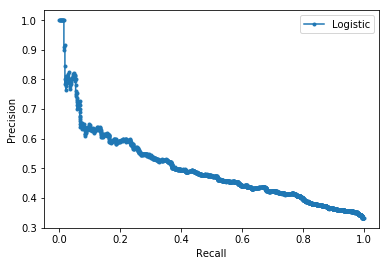

In [74]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

lr_precision, lr_recall, _ = precision_recall_curve(ytest, predictions[:,1])

plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()


In [47]:
ytest[0:10]

1721    0
1667    0
4538    1
918     0
1883    0
4636    1
2293    0
981     0
3043    0
3849    0
Name: link, dtype: int64

In [41]:
predictions.shape

(1800, 2)

In [52]:
predictions[0:3,]

array([[0.50795605, 0.49204395],
       [0.50332118, 0.49667882],
       [0.51536009, 0.48463991]])

## Train the link prediction model

There are a few steps involved in using the model to perform link prediction:
1. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge.
2. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict the probability indicating whether an edge between two nodes should exist or not.
3. To use the embeddings in a traditional machine learning classifier, we use binary operators on the embeddings such as average, Hadamard, L1, L2. Here we use the 'average operator' with node embeddings in the logistic regression classifier.
